<a href="https://colab.research.google.com/github/eamirhn/Kaggle-Projects/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
dataset_directory = "Brain Tumor Data Set/Brain Tumor Data Set"

# Check if the dataset directory exists
if not os.path.exists(dataset_directory):
    # Download the dataset
    !kaggle datasets download -d preetviradiya/brian-tumor-dataset

    # Unzip the dataset without printing output
    !unzip -qq "brian-tumor-dataset.zip"

    # Delete the zip file
    os.remove("brian-tumor-dataset.zip")
else:
    print("Dataset already exists. Skipping download and unzip steps.")

 90% 97.0M/107M [00:01<00:00, 123MB/s]
100% 107M/107M [00:01<00:00, 96.1MB/s]


In [4]:
!pip install split-folders
!pip install torch-summary

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image # A module that Provides functionality for image file formats.
from torch.utils.data import Dataset # For accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module for editing images
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # For efficient looping and combining of iterables.
from tqdm.notebook import trange, tqdm # For progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Reading data
labels_df = pd.read_csv('/content/metadata.csv')
labels_df.head()

Unnamed: 0            image  class format mode          shape
0           0   Cancer (1).jpg  tumor   JPEG  RGB  (512, 512, 3)
1           1   Cancer (1).png  tumor    PNG    L     (300, 240)
2           2   Cancer (1).tif  tumor   TIFF  RGB  (256, 256, 3)
3           3  Cancer (10).jpg  tumor   JPEG  RGB  (512, 512, 3)
4           4  Cancer (10).tif  tumor   TIFF  RGB  (256, 256, 3)

In [7]:
os.listdir('/content/Brain Tumor Data Set/Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

In [8]:
labels_df.shape

(4600, 6)

In [9]:
# Dataset Path
data_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = '/content/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:01, 3998.51 files/s]


In [10]:
# Image Augmentation
  # define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [11]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

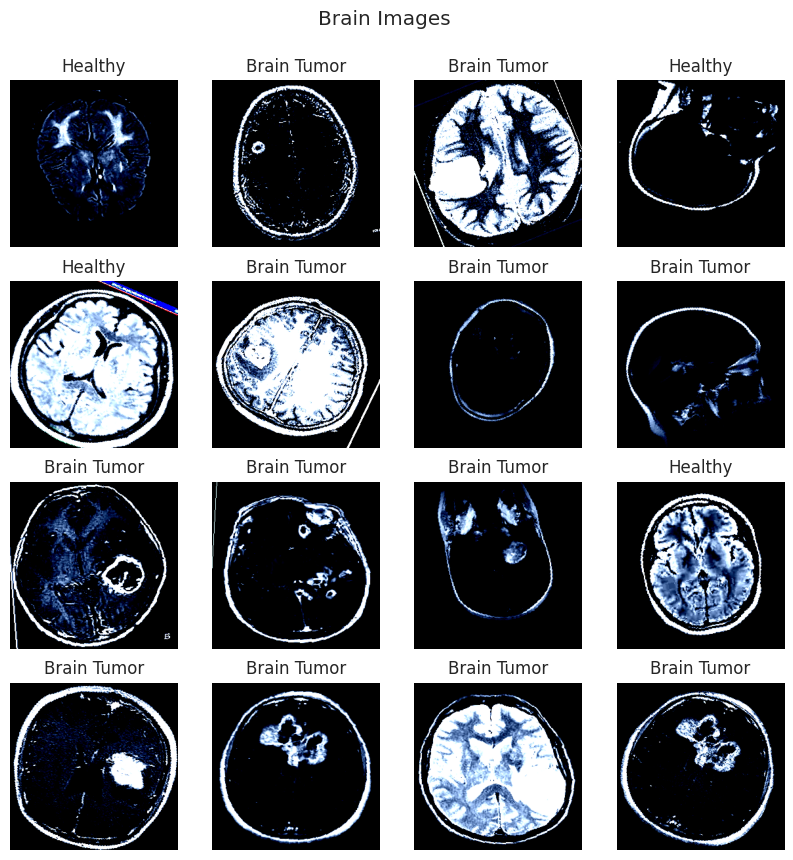

In [12]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [13]:
# Data Loader
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

In [14]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



In [15]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

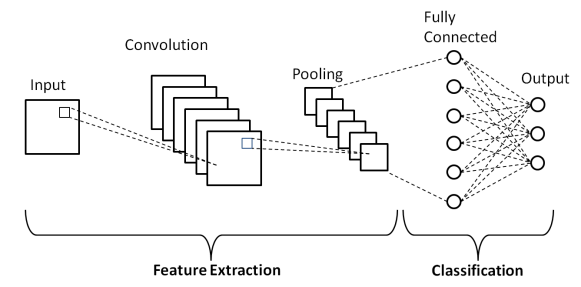

In [16]:
# Define Architecture For CNN_TUMOR Model
class CNN_TUMOR(nn.Module):

    # Network Initialisation
    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)


In [17]:
params_model={
        "shape_in": (3,256,256),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [18]:
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

In [19]:
loss_func = nn.NLLLoss(reduction="sum")

In [20]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

# Train

In [20]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [21]:
def Train_Val(model, params,verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss=float('inf')

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [22]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
#cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)
cnn_model = torch.load('/content/Brain_Tumor_model.pt')
cnn_model.eval()  # Set the model to evaluation mode

# Optionally, move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

CNN_TUMOR(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [23]:
# Convergence History Plot
# epochs=params_train["epochs"]
# fig,ax = plt.subplots(1,2,figsize=(12,5))

# sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
# sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
# sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
# sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

# Pytorch Grad-Cam

In [21]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [30]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = torch.load('/content/Brain_Tumor_model.pt')
model.eval()
image_url = "/content/brain/train/Brain Tumor/Cancer (1).jpg"
img = np.array(Image.open(image_url))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.conv4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

RuntimeError: shape '[-1, 12544]' is invalid for input of size 9216

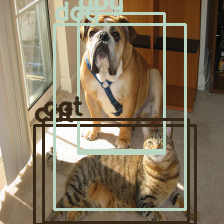

# Visualization

In [ ]:
def Ture_and_Pred(val_loader, model):
    y_true = []
    y_pred = []
    incorrect_predictions = []  # Store tuples of (image, true_label, predicted_label) for incorrect predictions
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true.extend(labels)
        y_pred.extend(pred)

        # Check for incorrect predictions
        incorrect_mask = pred != labels
        for idx, incorrect in enumerate(incorrect_mask):
            if incorrect:
                incorrect_predictions.append((images[idx], labels[idx], pred[idx]))

    return y_true, y_pred, incorrect_predictions

# Obtain true labels, predicted labels, and incorrect predictions
y_true, y_pred, incorrect_predictions = Ture_and_Pred(val_loader, cnn_model)


In [ ]:
print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

In [ ]:
# Visualization of incorrectly predicted images
figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 7
for i in range(1, min(cols * rows, len(incorrect_predictions)) + 1):  # Limit to the number of incorrect predictions
    img, true_label, predicted_label = incorrect_predictions[i-1]  # Get image, true label, and predicted label
    figure.add_subplot(rows, cols, i)
    plt.title(f"True: {CLA_label[true_label]}, Predicted: {CLA_label[predicted_label]}")
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Incorrectly Predicted Images', y=0.95)
plt.show()


In [ ]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(7,4))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

In [ ]:
#To save the model
#torch.save(cnn_model, "Brain_Tumor_model.pt")

# Heat Map with **Pytorch**

# Heat Map

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import pathlib
import os
import string
from PIL import Image
from keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
ge = ImageDataGenerator(rescale = 1/255,
                        rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        fill_mode = 'constant',
                        validation_split = 0.2,
                        horizontal_flip = True,
                        vertical_flip = True,
                        zoom_range = 0.2
                        )

In [ ]:
datasetfolder = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
dataflowtraining = ge.flow_from_directory(directory = datasetfolder,
                                 target_size = (224, 224),
                                 color_mode = 'rgb',
                                 batch_size = 32,
                                 shuffle = True,
                                 subset = 'training')
dataflowvalidation = ge.flow_from_directory(directory = datasetfolder,
                                           target_size = (224, 224),
                                           color_mode = 'rgb',
                                           batch_size = 32,
                                           shuffle = True,
                                           subset = 'validation')

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [ ]:
images, labels = dataflowvalidation.next()
np.min(images), np.max(images)

(0.0, 1.0)

In [ ]:
# images, labels = dataflowvalidation.next()
# plt.figure(figsize = (12, 12))
# for i in range(32):
#     plt.subplot(6, 6, (i + 1))
#     plt.imshow(images[i])
#     plt.title(labels[i])
# plt.legend()

In [ ]:
from keras.applications import DenseNet121
basemodel = DenseNet121(weights = 'imagenet', include_top = False,
                        input_shape = (224, 224, 3), pooling = None)
x = tf.keras.layers.Flatten()(basemodel.output)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(16, activation = 'relu',)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(2, activation = 'softmax')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy',
          optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
         metrics = ['accuracy', tf.keras.metrics.Precision(name = 'precision'),
                   tf.keras.metrics.Recall(name = 'recall')])

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
hist = m.fit(dataflowtraining, epochs = 60, batch_size = 32,
             validation_data = dataflowvalidation,
             callbacks = [
                tf.keras.callbacks.EarlyStopping(patience = 8, monitor = 'val_loss', mode = 'min',
                                                restore_best_weights = True),
                tf.keras.callbacks.ReduceLROnPlateau(patience = 6, monitor = 'val_loss',
                                                          mode = 'min', factor = 0.1)
            ])

Epoch 1/60
116/116 [==============================] - 162s 714ms/step - loss: 0.6538 - accuracy: 0.7180 - precision: 0.7180 - recall: 0.7180 - val_loss: 0.5239 - val_accuracy: 0.7508 - val_precision: 0.7508 - val_recall: 0.7508 - lr: 1.0000e-04
Epoch 2/60
116/116 [==============================] - 72s 620ms/step - loss: 0.4837 - accuracy: 0.8797 - precision: 0.8797 - recall: 0.8797 - val_loss: 0.3409 - val_accuracy: 0.9108 - val_precision: 0.9108 - val_recall: 0.9108 - lr: 1.0000e-04
Epoch 3/60
116/116 [==============================] - 71s 609ms/step - loss: 0.4174 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - val_loss: 0.3212 - val_accuracy: 0.9238 - val_precision: 0.9238 - val_recall: 0.9238 - lr: 1.0000e-04
Epoch 4/60
116/116 [==============================] - 74s 633ms/step - loss: 0.3667 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - val_loss: 0.3610 - val_accuracy: 0.8966 - val_precision: 0.8966 - val_recall: 0.8966 - lr: 1.0000e-04
Epoch 5/60
116/116 [===

In [ ]:
m.evaluate(dataflowtraining)

116/116 [==============================] - 49s 420ms/step - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


[0.008523709140717983, 1.0, 1.0, 1.0]

In [ ]:
m.evaluate(dataflowvalidation)

29/29 [==============================] - 11s 371ms/step - loss: 0.0118 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989


[0.011848601512610912,
 0.9989118576049805,
 0.9989118576049805,
 0.9989118576049805]

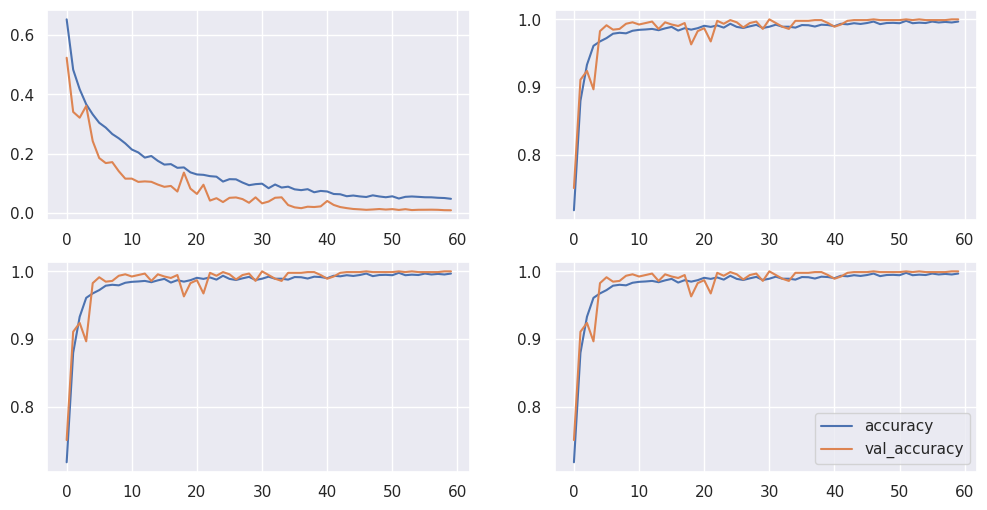

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))
metrics = ['loss', 'precision', 'recall', 'accuracy']
for i in range(4):
    plt.subplot(2, 2, (i + 1))
    plt.plot(hist.history[metrics[i]], label = metrics[i])
    plt.plot(hist.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
plt.legend()

In [ ]:
m.save('/content/final_tumor_model.h5')

In [ ]:
def readtumorImages(imagespathes):
    images = []
    for img in imagespathes:
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255
        img = cv2.resize(img, (224, 224))
        images.append(img)
    return np.array(images)

In [ ]:
images = readtumorImages(list(pathlib.Path('/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor').glob('*.*'))[:1000])
labels = tf.keras.utils.to_categorical(tf.zeros(shape = (images.shape[0])), num_classes = 2)
images.shape, labels.shape

((1000, 224, 224, 3), (1000, 2))

In [ ]:
indexs = np.random.choice(range(images.shape[0]), size = (images.shape[0], ))
images = images[indexs]
labels = labels[indexs]
images.shape, labels.shape

((1000, 224, 224, 3), (1000, 2))

In [ ]:
m = tf.keras.models.load_model('/content/drive/MyDrive/final_tumor_model.h5')

In [ ]:
def gradCam(image, true_label, layer_conv_name):
    model_grad = tf.keras.models.Model(inputs = m.input,
                                  outputs = [m.get_layer(layer_conv_name).output,
                                             m.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = model_grad(image)
        tape.watch(conv_output)
        loss = tf.losses.binary_crossentropy(true_label, predictions)
    grad = tape.gradient(loss, conv_output)
    grad = K.mean(tf.abs(grad), axis = (0, 1, 2))
    conv_output = np.squeeze(conv_output.numpy())
    for i in range(conv_output.shape[-1]):
        conv_output[:,:, i] = conv_output[:,:, i]*grad[i]
    heatmap = tf.reduce_mean(conv_output, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap/tf.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    return np.squeeze(heatmap), np.squeeze(image)

In [ ]:
def getHeatMap(images, labels):
    heatmaps = []
    for index in range(128):
        heatmap, image = gradCam(images[index: index + 1],
                                               labels[index: index + 1],
                                           'relu')
        heatmaps.append(heatmap)
    return np.array(heatmaps)

In [ ]:
heatmaps = getHeatMap(images, labels)
heatmaps.shape

(128, 224, 224)

In [ ]:
def grad_cam_plus_plus(image, true_label, conv_layer):
    gradModel = tf.keras.models.Model(inputs = m.input, outputs = [
        m.get_layer(conv_layer).output,
        m.output
    ])
    with tf.GradientTape() as tape:
        conv_output, predict = gradModel(image)
        tape.watch(conv_output)
        score = predict[:, np.argmax(predict,)]
    grads = tape.gradient(score, conv_output)
    grads = K.mean(tf.abs(grads), axis = [0, 1, 2])
    first = K.exp(score)*grads
    second = K.exp(score)*grads*grads
    third = K.exp(score)*grads*grads*grads
    conv_output = np.squeeze(conv_output)
    x = conv_output
    x = np.sum(np.sum(x, axis = 0), axis = 0)
    grads = (second)/(2*second + third*x)
    conv_output = np.array(conv_output)
    for i in range(conv_output.shape[-1]):
        conv_output[:,:,i] = conv_output[:,:,i]*grads[i]
    conv_output = tf.reduce_mean(conv_output, axis = -1)
    heatmap = np.maximum(conv_output, 0)
    heatmap = heatmap/np.max(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

In [ ]:
def getHeatMap_plus_plus(images, labels):
    heatmaps = []
    for index in range(128):
        heatmap = grad_cam_plus_plus(images[index: index + 1],
                                               labels[index: index + 1],
                                           'relu')
        heatmaps.append(heatmap)
    return np.array(heatmaps)

In [ ]:
GradCamplusheatmaps = getHeatMap_plus_plus(images, labels)
GradCamplusheatmaps.shape

(128, 224, 224)

In [ ]:
def draw_compare(images, gradcam_heatmaps,
                 gradcamplus_heatmaps, labels):
  plt.figure(figsize = (12, 50))
  index = 0
  n = 0
  for i in range(120):
    plt.subplot(20, 6, (i + 1))
    if index == 0:
      plt.imshow(images[n])
      plt.title('Image-class: {}'.format(labels[n]))
      index = 1
    elif index == 1:
      plt.imshow(images[n])
      plt.imshow(gradcam_heatmaps[n], alpha = 0.6, cmap = 'jet')
      plt.title('Grad-Cam')
      index = 2
    elif index == 2:
      plt.imshow(images[n])
      plt.imshow(gradcamplus_heatmaps[n], alpha = 0.6, cmap = 'jet')
      plt.title('Grad-Cam++')
      index = 0
      n = n + 1
  plt.legend()

In [ ]:
l = np.argmax(labels, axis = 1)
l.shape

(1000,)

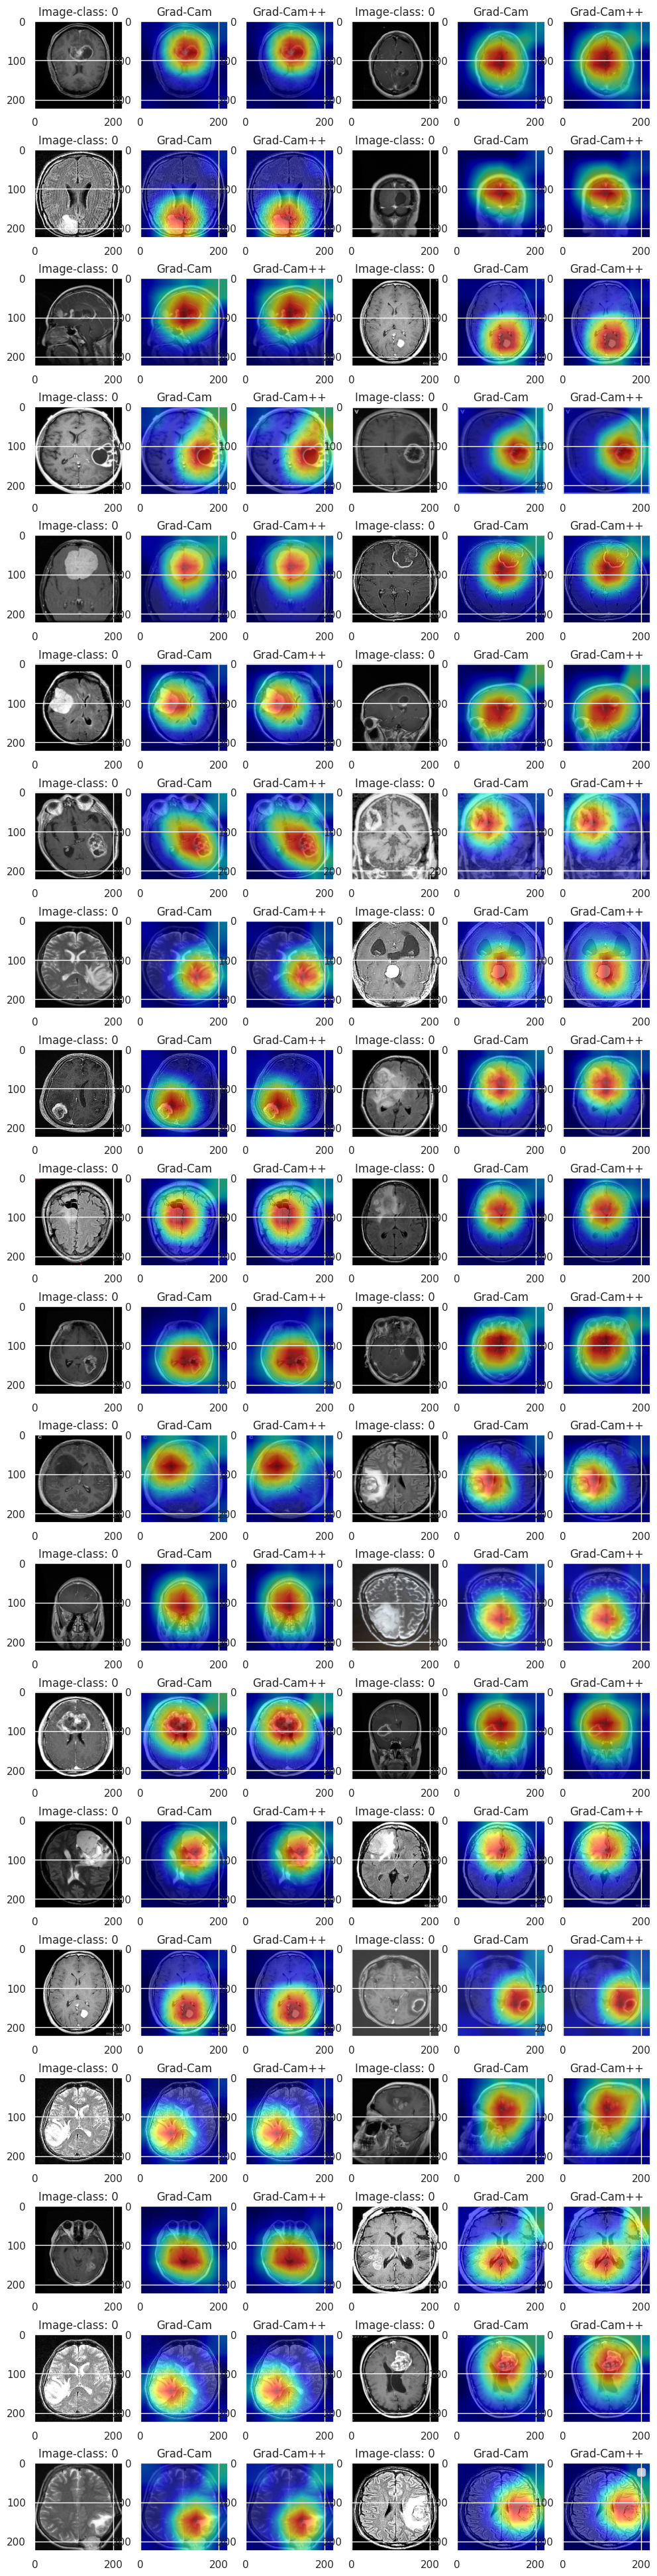

In [ ]:
draw_compare(images[:40], heatmaps[:40],
                 GradCamplusheatmaps[:40], l[:40])

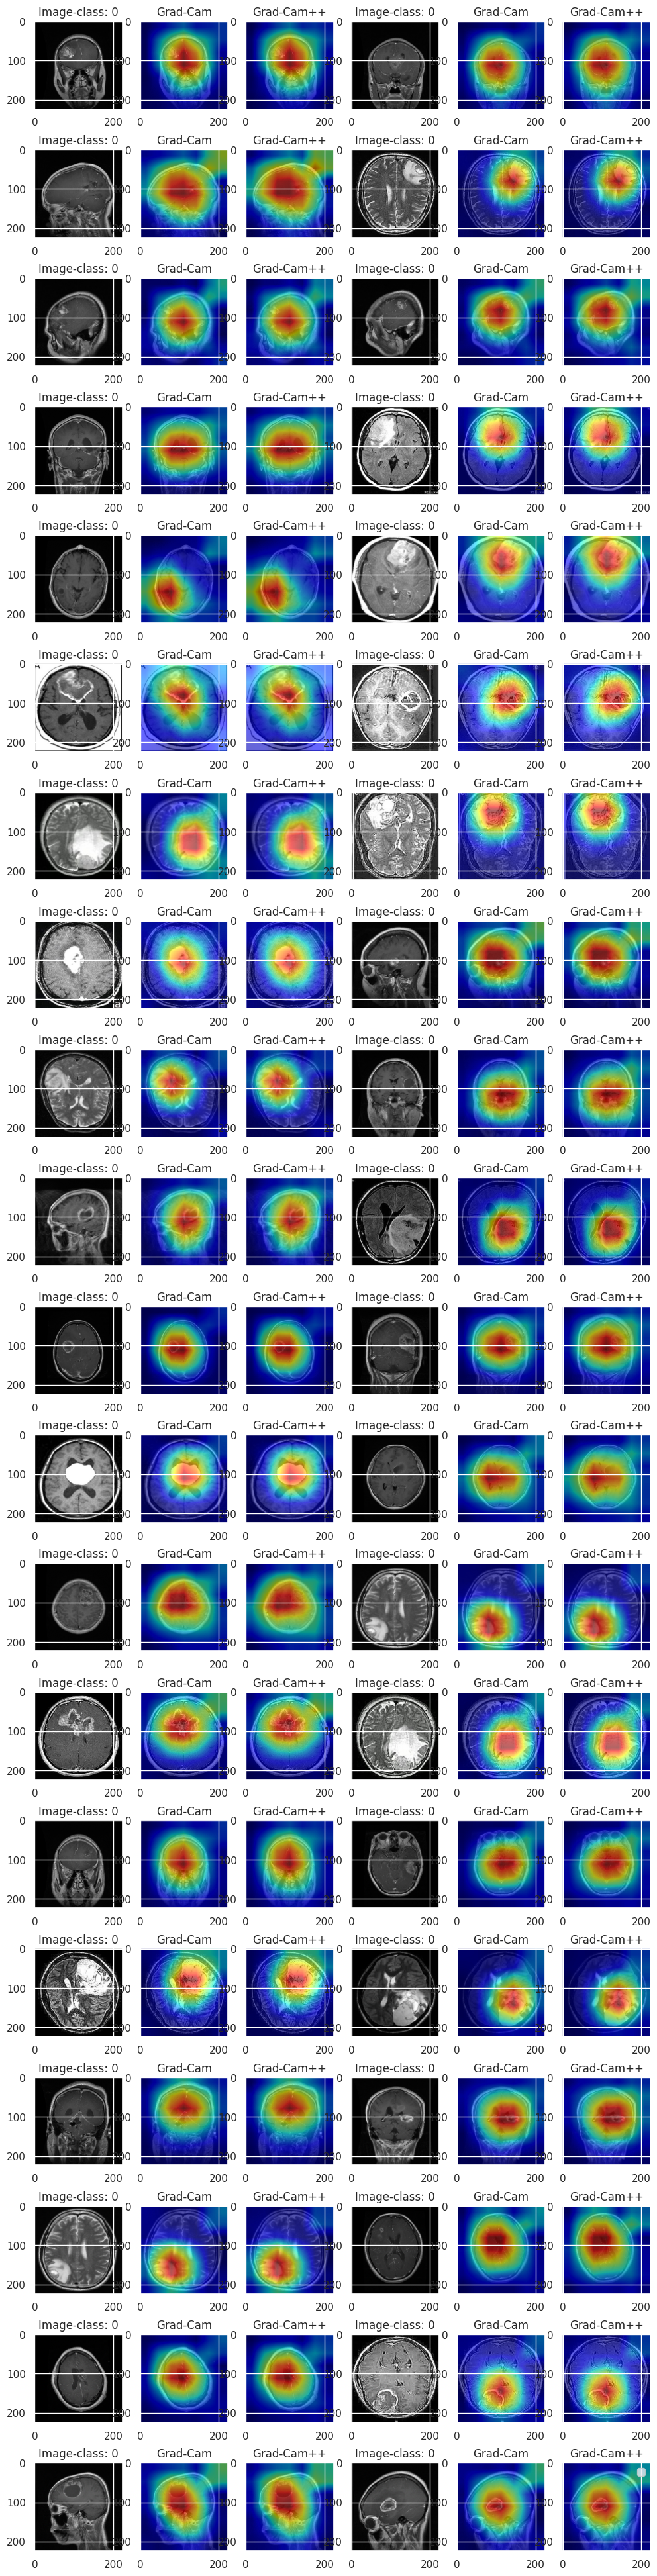

In [ ]:
draw_compare(images[40:80], heatmaps[40:80],
                 GradCamplusheatmaps[40:80], l[40:80])

# Risk Images

In [ ]:
def get_tumor_probability(image, model):
    """
    Get the probability of an image belonging to the Tumor class predicted by the model.

    Args:
    image (torch.Tensor): Input image tensor.
    model (torch.nn.Module): Trained PyTorch model.

    Returns:
    float: Probability of the image belonging to the Tumor class predicted by the model.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Make a forward pass
        probabilities = torch.softmax(output, dim=1)  # Apply softmax to get probabilities
        tumor_probability = probabilities[:, 0].item()  # Get the probability of class 0 (Tumor)
    return tumor_probability

In [ ]:
figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 7
for i in range(1, min(cols * rows, len(incorrect_predictions)) + 1):  # Limit to the number of incorrect predictions
    img, true_label, predicted_label = incorrect_predictions[i-1]  # Get image, true label, and predicted label

    # Calculate probability of the predicted label
    probability = get_image_probability(img, cnn_model)

    figure.add_subplot(rows, cols, i)
    plt.title(f"Tr: {CLA_label[true_label]}, Pr: {CLA_label[predicted_label]}, P: {probability:.2f}")
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Incorrectly Predicted Images with Probabilities', y=0.95)
plt.show()

NameError: name 'get_image_probability' is not defined

<Figure size 2000x2000 with 0 Axes>

In [ ]:
def get_incorrect_predictions(images, labels, model):
    """
    Get the incorrect predictions along with their probabilities from a batch of images and labels predicted by the model.

    Args:
    images (torch.Tensor): Batch of input image tensors.
    labels (torch.Tensor): Ground truth labels for the input images.
    model (torch.nn.Module): Trained PyTorch model.

    Returns:
    list: List of tuples containing incorrect predictions and their probabilities.
    """
    model.eval()  # Set the model to evaluation mode
    incorrect_predictions = []

    with torch.no_grad():
        outputs = model(images)  # Make a forward pass
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        predicted_labels = torch.argmax(outputs, dim=1)  # Get predicted labels

        for i in range(len(labels)):
            if predicted_labels[i] != labels[i]:  # Check if prediction is incorrect
                incorrect_predictions.append((images[i], labels[i], predicted_labels[i], probabilities[i, labels[i]].item()))

    return incorrect_predictions


In [ ]:
incorrect_predictions = get_incorrect_predictions(images, labels, model)

# Display the incorrect predictions along with their probabilities
figure = plt.figure(figsize=(10, 10))
num_images = len(incorrect_predictions)
cols = 4,7

for i, (image, true_label, predicted_label, probability) in enumerate(incorrect_predictions, 1):
    figure.add_subplot(rows, cols, i)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}\nProbability: {probability:.4f}")
    plt.axis("off")
    img_np = image.permute(1, 2, 0).cpu().numpy()  # Convert image tensor to numpy array
    img_valid_range = np.clip(img_np, 0, 1)  # Clip pixel values to [0, 1]
    plt.imshow(img_valid_range)

plt.tight_layout()
plt.show()

NameError: name 'images' is not defined

Using transfer learning VGG16

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, device):
    model.to(device)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}, Training')
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Pass inputs through the model and obtain the output logits
            outputs = model(inputs)

            # Compute the loss between the model's output and the ground truth labels
            loss = criterion(outputs, labels)

            # Perform backpropagation to compute gradients
            loss.backward()

            # Update the model's parameters based on the computed gradients
            optimizer.step()

            # Add the current loss to the running total of losses
            total_loss += loss.item()

            # Extract the class with the highest score for each instance in the batch
            _, predicted = torch.max(outputs, 1)

            # Count the number of correct predictions
            correct += (predicted == labels).sum().item()

            total += labels.size(0)
            train_bar.set_postfix(loss=f'{total_loss / len(train_loader):.4f}', accuracy=f'{correct / total:.4f}')

        train_accuracy = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        total = 0
        correct = 0
        valid_loss = 0.0
        valid_bar = tqdm(valid_loader, desc=f'Epoch {epoch + 1}/{epochs}, Validation')
        with torch.no_grad():
            for inputs, labels in valid_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Pass inputs through the model and obtain the output logits
                outputs = model(inputs)

                # Compute the loss between the model's output and the validation set labels
                loss = criterion(outputs, labels)

                # Add the current loss to the running total of validation losses
                valid_loss += loss.item()

                # Extract the class with the highest score for each instance in the batch
                _, predicted = torch.max(outputs, 1)

                # Count the number of correct predictions
                correct += (predicted == labels).sum().item()

                total += labels.size(0)
                valid_bar.set_postfix(loss=f'{valid_loss / len(valid_loader):.4f}', accuracy=f'{correct / total:.4f}')

            valid_accuracy = correct / total
            valid_losses.append(valid_loss / len(valid_loader))
            valid_accuracies.append(valid_accuracy)

            print(f'Epoch {epoch + 1}/{epochs}, Validation Accuracy: {valid_accuracy:.4f}')

    print('Training complete.')

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [ ]:
pip -q install efficientnet_pytorch

  Preparing metadata (setup.py) ... done


In [ ]:
# Mode 2: Transfer Learning
from efficientnet_pytorch import EfficientNet

# Define VGG16 model with transfer learning
model_transfer_learning = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier to match the number of classes in your dataset
num_classes = 2
num_ftrs = model_transfer_learning._fc.in_features
model_transfer_learning._fc = nn.Linear(num_ftrs, num_classes)

# Define loss function
criterion_transfer_learning = nn.CrossEntropyLoss()

# Define optimizer without weight decay for regularization
# use SGD as optimizer
# set learning rate to 0.001 and momentum to 0.9
optimizer_transfer_learning = optim.SGD(model_transfer_learning.parameters(), lr=0.001, momentum=0.9)

# Train the model using the train_model function
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model_transfer_learning,
    train_loader,
    val_loader,
    criterion_transfer_learning,
    optimizer_transfer_learning,
    epochs=10,
    device=DEVICE
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 196MB/s]

Loaded pretrained weights for efficientnet-b0


Epoch 1/10, Training:   0%|          | 0/58 [00:00<?, ?it/s]

In [ ]:
# Function to plot loss and accuracy curves
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plotting Loss Curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
test_model(model_transfer_learning, test_loader, criterion_transfer_learning, device=DEVICE)